#  Examples - Neuropsychiatric traits

**Related to Figure 6.**  

Datasets generated:
- Figure 6A
- Figure 6B Edgelist and Node information


### Set Up

In [28]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import sklearn.preprocessing as prep
import statsmodels.api as sm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [30]:
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, '../carva'))
from network_utils import *
from geneset_utils import *
from hierarchy_utils import *


In [31]:
datadir=os.path.join(cwd, '..')
outdir=os.path.join(datadir, 'outputs')

In [34]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.5
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data/Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'
purple='#441f5d'
raspberry='#b4436c'

## Import Data

In [147]:
coloc_df = pd.read_csv(os.path.join(outdir, 'STable2.tsv'), sep='\t')
best_df = coloc_df[coloc_df['Optimal COLOC']]

In [148]:
info_df = pd.read_csv(os.path.join(outdir, 'STable1.tsv'), sep='\t', usecols=['Mapped EFO', 'Trait Type', 
                                                                              'Biological Domain', 'Mapped Trait']).drop_duplicates()
info_df.columns = ['TRAIT', 'EFO', 'trait_type', 'Domain']

In [149]:
best_df = best_df.reset_index().merge(domain_info.loc[:, ('EFO', 'Domain', 'trait_type')], on=['EFO'], how='left')

In [150]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [151]:
best_df = get_trait_pair(best_df)

In [152]:
npd_df_full = best_df[best_df.EFO.isin(domain_info[domain_info.Domain.isin(['Neurological', 'Psychiatric'])].EFO.values)]
npd_df = npd_df_full[(npd_df_full.Log2SizeOE >= 0 ) & (npd_df_full['COLOC p'] < 0.01) ].copy()
print('Total Neuropsychiatric Traits:', len(npd_df_full))
print('Neuropsychiatric Traits with at least Moderate Coloc:', len(npd_df))

Total Neuropsychiatric Traits: 21
Neuropsychiatric Traits with at least Moderate Coloc: 14


In [153]:
efo_list = npd_df.EFO.values

### Load subnetworks

In [122]:
uuid_list = pd.read_csv(os.path.join(cwd, '../outputs/uuid_list.txt'), sep='\t')
uuid_list['EFO'] = uuid_list.TraitR.apply(lambda z: z.split('_', 1)[-1])
uuid_dict = uuid_list.set_index('EFO')['uuid'].to_dict()

In [58]:
username=getpass('Username:')
password = getpass('Password')

Username:········
Password········


In [82]:
node_lists = {}
for efo in efo_list:
    uuid = uuid_dict[efo]
    G = load_network(uuid, use_password=True, ndex_password=password, ndex_user=username, verbose=False)
    node_lists[efo] = [int(n) for n in G.nodes()]

### Load Features

In [154]:
all_feat = pd.read_csv(os.path.join(datadir, 'outputs/STable4.tsv'), sep='\t')
all_feat.head()

,EFO,Common Study,Rare Study,log2COLOC,N_C,N_R,binary,g_C,g_R,J_RC,...,Mean_LOEUF,DiffRC_LOEUF,Mean_GeneSize,DiffRC_GeneSize,Mean_GO,DiffRC_GO,Mean_mRNA,DiffRC_mRNA,Mean_nTissues,DiffRC_nTissues
0,EFO_0001645,GCST010866,19847924,0.114939,649058.0,4764.0,1,99,6,0.0,...,3.571876,-0.970322,111587.000000,-1.389547,19.771429,-0.222222,13.801416,-0.415252,52.971429,-0.009479
1,EFO_0001645,GCST011488,19847924,-0.114747,66643.0,4764.0,1,5,6,0.0,...,2.362307,-0.958482,75381.090909,-1.478176,17.363636,-0.171429,7.956012,0.360069,52.727273,-0.009479
2,EFO_0001645,GCST90132305,19847924,0.257235,1077578.0,4764.0,1,35,6,0.0,...,2.441375,-0.689403,156237.000000,-1.579342,15.146341,0.064516,8.089873,0.156914,52.073171,0.009569
3,EFO_0001645,GCST90446534,19847924,-0.107372,459138.0,4764.0,1,33,6,0.0,...,3.289389,-0.958482,92777.000000,-1.335380,21.076923,-0.315789,9.984043,-0.091197,51.230769,0.028986
4,EFO_0001645,GCST90449059,19847924,0.020130,640258.0,4764.0,1,32,6,0.0,...,3.047721,-0.896941,85553.131579,-1.289639,22.315789,-0.379747,13.666197,-0.443203,52.500000,0.000000


In [155]:
all_feat = get_trait_pair(all_feat).set_index('trait_pair')
all_feat.index.name=''

## Figure 6A

In [156]:
npd_feat = all_feat.loc[npd_df.trait_pair.values]

In [161]:
trait_labels={'autism spectrum disorder':'ASD', 'Alzheimer disease':'AD',
       'whole-brain volume':'WBV', 'bipolar disorder':'BD', 'multiple sclerosis':'MS',
       'obsessive-compulsive disorder':'OCD', 'insomnia':'Insomnia', 'epilepsy':'Epilepsy',
       'schizophrenia':'SCZ', 'carpal tunnel syndrome':'Carpal Tunnel Synd.', 'partial epilepsy':'Partial Epilepsy',
       'migraine disorder':'Migraine', 'Headache': 'Headache', 'Vertigo':'Vertigo'}

In [159]:
plot_df = npd_feat.loc[:, ('EFO', 'log2COLOC', 'g_R', 'g_C')].merge(npd_df.loc[:, 
                ('Trait', 'Domain', 'trait_type', 'nShared', 'COLOC -logp', 'EFO')], on=['EFO'], how='left')

In [166]:
plot_df['TRAIT'] = plot_df['Trait'].map(trait_labels)

In [162]:
plot_df['Domain'] = plot_df.Domain.map({'Psychiatric': 1, 'Neurological':2})
plot_df['trait_type'] = plot_df.trait_type.map({'CC':1, 'Q': 0})
plot_df['g_R'] = plot_df.g_R.apply(lambda x: np.log10(x))
plot_df['g_C'] = plot_df.g_C.apply(lambda x: np.log10(x))
plot_df['plotq'] = plot_df['COLOC -logp'].apply(lambda x: min(x, 50))

In [171]:
plot_df = plot_df.sort_values('log2COLOC', ascending=False)

Text(0, 0.5, 'COLOC Score')

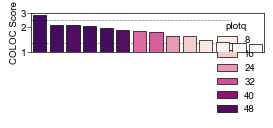

In [172]:
_ = plt.figure(figsize=(3, 0.5))
plt.hlines(y=[np.log2(1.3), np.log2(2.5)], xmin=-0.5, xmax=11.5, color='grey', linestyle='--', linewidth=0.5
          )
sns.barplot(plot_df, x='TRAIT', y='log2COLOC', hue='plotq', palette='RdPu', edgecolor='black', zorder=10)
_ = plt.xticks([])
_ = plt.xlabel('')
_ = plt.yticks([0, 1, np.log2(3)], labels=[1, 2, 3])
plt.ylabel('COLOC Score')
#plt.savefig(os.path.join(figdir, 'npd_coloc.svg'), bbox_inches='tight')

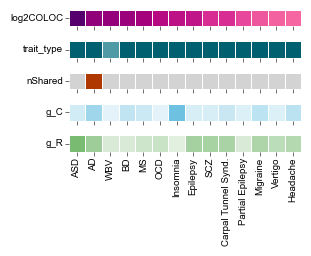

In [173]:
import matplotlib as mpl
_, axs = plt.subplots(ncols=1, nrows=5, sharex=True, gridspec_kw={'height_ratios':[1,1,1,1,1], 'hspace':0.1}, 
                     figsize=(3, 2))

metrics = [['log2COLOC'], ['trait_type'], ['nShared'], ['g_C'], ['g_R']]
cmaps = ['RdPu', 
         sns.blend_palette(['#509aa5', binary], as_cmap=True), 
         sns.blend_palette(['lightgrey', shared], as_cmap=True), 
         sns.blend_palette(['white', blue], as_cmap=True), 
         sns.blend_palette(['white', green], as_cmap=True),
         sns.blend_palette(['white', '#F78154'], as_cmap=True),
         'vlag']
norms = [mpl.colors.Normalize(vmin=-1, vmax=np.log2(3)),
        None,
        None,
        mpl.colors.Normalize(vmin=0, vmax=2.5),
        mpl.colors.Normalize(vmin=0, vmax=2.5),
        None,
        None]


ylabels=['COLOC Score', 'Trait Type', 'Shared Genes', 'CVGs', 'RVGs']

for i in range(0, 5):
    sns.heatmap(plot_df.loc[:, ['TRAIT'] + metrics[i]].set_index('TRAIT').T, ax=axs[i], cmap=cmaps[i], square=True, 
           linecolor='white', linewidth=0.5, norm=norms[i], cbar=False)
    axs[i].tick_params(axis='y', rotation=0)
    axs[i].set_xlabel('')
plt.savefig(os.path.join(figdir, 'npd_features.svg'), bbox_inches='tight')

In [179]:
npd_df.sort_values(by='COLOC p', ascending=True).loc[:, ['Trait', 'COLOC p', 'Log2SizeOE']].head(3)

,Trait,COLOC p,Log2SizeOE
45,autism spectrum disorder,2.740000e-266,1.494694
349,Alzheimer disease,2.162000e-87,1.119217
351,bipolar disorder,1.940000e-58,1.042778


## Trait Similarity

In [63]:
## Load all_zscores
def load_z(trait, datadir, transform, norm, rorc):
    df = pd.read_csv(os.path.join(datadir, f'{trait}_z_{rorc}V_q_{transform}_{norm}.tsv'), sep='\t', header=None,
                    index_col=0, names=['z']).dropna()
    return df

def load_all_scores(df, datadir, rorc):
    allz = {}
    if rorc == 'C':
        other = 'TraitR'
    else:
        other = 'TraitC'
    for i, t in tqdm(enumerate(list(df[f'Trait{rorc}'].values))):
        if rorc == 'R':
            other = 'TraitC'
            allz[f'{t}_{df[other].values[i]}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
        else:
            other = 'TraitR'
            allz[f'{df[other].values[i]}_{t}'] = load_z(t, datadir, 'neglog10', 'sum', rorc=rorc).z.to_dict()
    z = pd.DataFrame.from_dict(allz)
    return z

In [77]:
npd_df['TraitR'] = npd_df['Rare Study'].astype(int).astype(str)+ '_' + npd_df['EFO']
npd_df['TraitC'] = npd_df['Common Study']+ '_' + npd_df['EFO']
npd_df['trait_pair'] = npd_df['TraitR'] + '_' + npd_df['TraitC']

In [70]:
z_dir = '/cellar/users/snwright/Data/RareCommon/'
zR = load_all_scores(npd_df, os.path.join(z_dir, 'outputs/netcoloc/March_2025'), 'R').dropna()
zC = load_all_scores(npd_df, os.path.join(z_dir, 'outputs/netcoloc/March_2025'), 'C').dropna()
z_coloc = zR * zC
z_coloc_order = z_coloc.columns

14it [00:00, 115.77it/s]
14it [00:00, 119.16it/s]


In [87]:
npd_df.columns

Index(['EFO', 'Trait', 'Common Study', 'Rare Study', 'Analysis Set', 'nCommon',
       'nRare', 'nShared', 'pShared', 'Network', 'Observed Size',
       'Expected Size', 'Log2SizeOE', 'COLOC Score', 'COLOC p', 'COLOC -logp',
       'Optimal COLOC', 'Observed Size PC22', 'Expected Size PC22',
       'Log2SizeOE PC22', 'COLOC Score PC22', 'COLOC P PC22',
       'COLOC -logp PC22', 'Observed Size HN', 'Expected Size HN',
       'Log2SizeOE HN', 'COLOC Score HN', 'COLOC P HN', 'COLOC -logp HN',
       'Observed Size ST', 'Expected Size ST', 'Log2SizeOE ST',
       'COLOC Score ST', 'COLOC P ST', 'COLOC -logp ST', 'TraitR', 'TraitC',
       'trait_pair'],
      dtype='object')

In [89]:
def get_similarities_df(npd_df, z_df, node_lists):
    cosine_sims = {}
    for tp, efo in zip(npd_df.trait_pair.values, npd_df.EFO.values):
        cosine_sims[tp] = {}
        for tp1, efo1 in zip(npd_df.trait_pair.values, npd_df.EFO.values):
            cosine_sims[tp][tp1] = cosine_similarity_of_subnetworks(z_df[tp], z_df[tp1], 
                                                                    node_lists[efo], node_lists[efo1])[0,1]
    out_sims = pd.DataFrame(cosine_sims).melt(var_name='trait2', value_name='Cosine', ignore_index=False).reset_index(names=['trait1'])
    #print(out_sims)
    out_sims['trait1'] = out_sims['trait1'].map(npd_df.set_index('trait_pair')['Trait'].to_dict())
    out_sims['trait2'] = out_sims['trait2'].map(npd_df.set_index('trait_pair')['Trait'].to_dict())
    out_sims['traitA'] = out_sims.apply(lambda z: sorted([z.trait1, z.trait2])[0], axis=1)
    out_sims['traitB'] = out_sims.apply(lambda z: sorted([z.trait1, z.trait2])[1], axis=1)
    out_sims = out_sims[out_sims.trait1 != out_sims.trait2]
    return out_sims.drop(columns=['trait1', 'trait2']).drop_duplicates(subset=['traitA', 'traitB'])


def cosine_similarity_of_subnetworks(z1, z2, sub1=None, sub2=None):
    gene_df = pd.DataFrame({'z1':z1, 'z2':z2}).fillna(0)
    if sub1 is not None:
        gene_df = gene_df.loc[list(set(sub1).union(set(sub2)))]
    return cosine_similarity(np.array(gene_df).T)
    

In [90]:
out_sims = get_similarities_df(npd_df, z_coloc, node_lists)
out_rare = get_similarities_df(npd_df, zR, node_lists)
out_common = get_similarities_df(npd_df, zC, node_lists)

In [91]:
out = out_rare.merge(out_common, on=['traitA', 'traitB'], suffixes=['_R', '_C']).merge(out_sims, on=['traitA', 'traitB'])

### Export similarity node and edge information 

In [94]:
out.to_csv(os.path.join(datadir, 'outputs/npd_similiarities.csv'), index=False)

In [93]:
npd_df.loc[:, ('Trait', 'Log2SizeOE', 'COLOC -logp', 'nCommon', 'nRare', 'nShared')].to_csv(os.path.join(datadir, 'outputs/npd_similiarities_nodes.csv'), index=False)

In [25]:
out.sort_values('Cosine', ascending=False)

,Cosine_R,traitA,traitB,Cosine_C,Cosine
6,0.485890,autism spectrum disorder,epilepsy,0.664921,0.483911
5,0.496724,autism spectrum disorder,insomnia,0.389807,0.463350
2,0.564635,autism spectrum disorder,bipolar disorder,0.640450,0.455083
63,0.485370,epilepsy,insomnia,0.368556,0.343820
39,0.387097,bipolar disorder,epilepsy,0.591045,0.329153
...,...,...,...,...,...
61,0.189895,Vertigo,obsessive-compulsive disorder,-0.175849,-0.050960
89,0.042257,Headache,migraine disorder,0.655678,-0.059287
82,0.206044,carpal tunnel syndrome,migraine disorder,0.024016,-0.059637
27,0.196788,obsessive-compulsive disorder,whole-brain volume,-0.152317,-0.077214


In [26]:
out[out.Cosine > 0.05]

,Cosine_R,traitA,traitB,Cosine_C,Cosine
2,0.564635,autism spectrum disorder,bipolar disorder,0.640450,0.455083
3,-0.080041,autism spectrum disorder,multiple sclerosis,-0.261567,0.078787
4,0.082418,autism spectrum disorder,obsessive-compulsive disorder,0.131821,0.121216
5,0.496724,autism spectrum disorder,insomnia,0.389807,0.463350
6,0.485890,autism spectrum disorder,epilepsy,0.664921,0.483911
7,0.069335,autism spectrum disorder,schizophrenia,0.618231,0.133457
8,-0.226152,autism spectrum disorder,carpal tunnel syndrome,-0.187613,0.095961
9,-0.069629,autism spectrum disorder,partial epilepsy,0.609386,0.065821
11,0.354986,Vertigo,autism spectrum disorder,0.302642,0.110910
12,0.395888,Headache,autism spectrum disorder,0.375373,0.231925
